# Why this notebook?
After reading and applying the concepts of the second chapter of the book Hands-on Machine Learning by Auréline Géron, I want to test my understanging. I'll replicate the end to end project on a new dataset.

# Goal
Predict a person medical insurance's charge.

# Retrieving data

In [4]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("mirichoi0218/insurance")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/d/mirichoi0218/insurance


In [5]:
import pandas as pd
file_path = "/kaggle/input/d/mirichoi0218/insurance/insurance.csv"
insurance = pd.read_csv(file_path)

insurance.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [6]:
insurance.isnull().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

# Separate the dataset
We now need to separate the dataset into two then two datasets. The first separation is to get the labels on one hand (what we want to predict) and the data on the other hand (what we'll use to predict). The second one is to get training data, and test data. We don't want our model to train on the test data to avoid overfitting.

In [7]:
# First separation
X = insurance.drop("charges", axis=1)
y = insurance["charges"]

In [8]:
# Second separation
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Discover the data
We know want to discover and visualize the data to gain insights.

The single most important part of the data is the label repartition.

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='charges', ylabel='Count'>

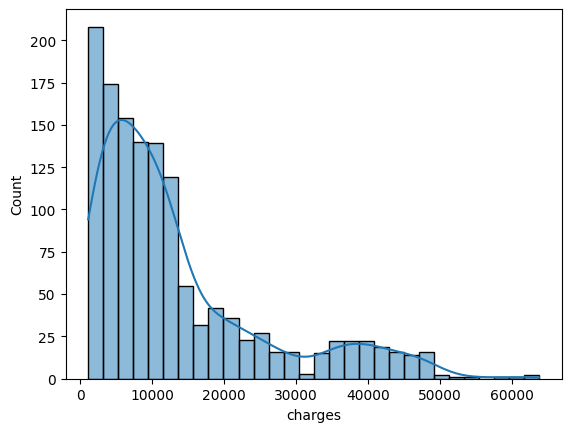

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.histplot(data=insurance["charges"], label="charges", kde=True)

It's skewed, most charges are low. We'll have to keep in mind when we train our model.

## Categorical data
Since it's pretty hard to work with categorical data (not a number) we're going to use boxplot to see how they affect the charges.

<Axes: xlabel='smoker', ylabel='charges'>

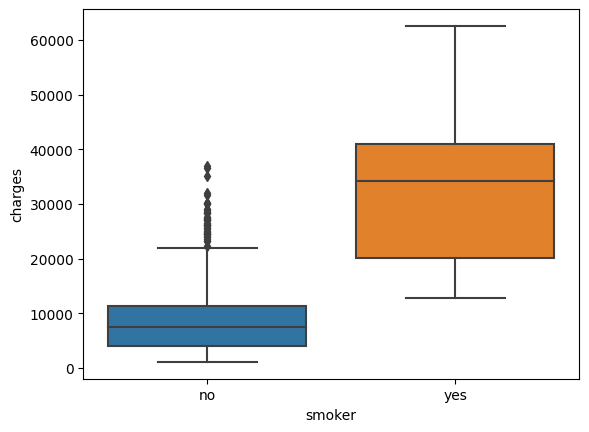

In [10]:
# Do smoker pay more?
sns.boxplot(x=X_train["smoker"], y=y_train)

<Axes: xlabel='sex', ylabel='charges'>

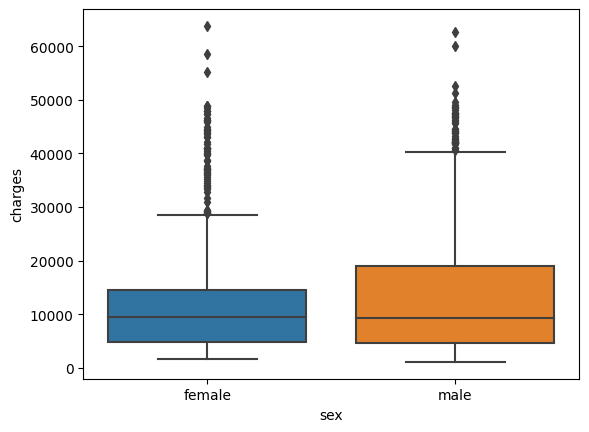

In [11]:
# Does sex affect the charges?
sns.boxplot(x="sex", y="charges", data=insurance)

<Axes: xlabel='region', ylabel='charges'>

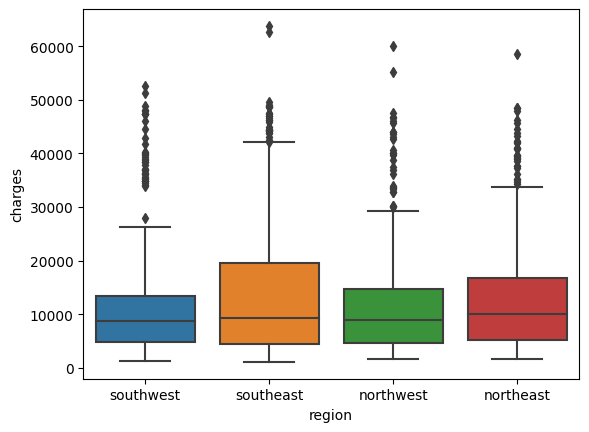

In [12]:
# Do charges depend on region?
sns.boxplot(x="region", y="charges", data=insurance)

## Numerical data
Visualizing correlation between numerical data and the charges is equally important.

/usr/local/lib/python3.11/dist-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


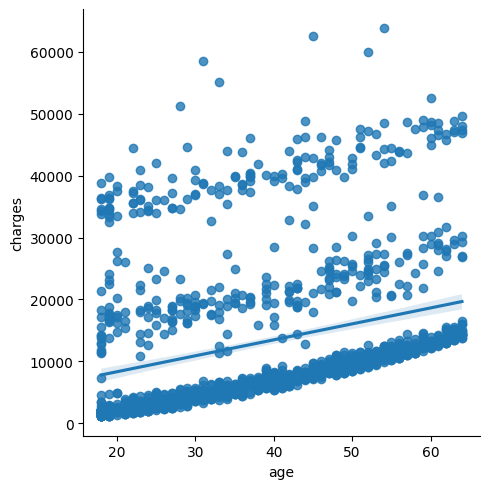

In [13]:
sns.lmplot(x="age", y="charges", data=insurance)

/usr/local/lib/python3.11/dist-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


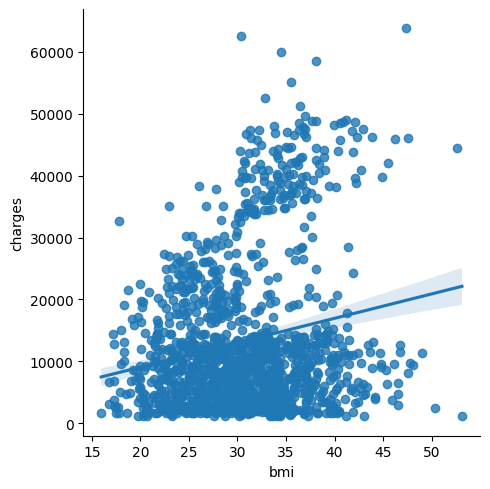

In [14]:
sns.lmplot(x="bmi", y="charges", data=insurance)

/usr/local/lib/python3.11/dist-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


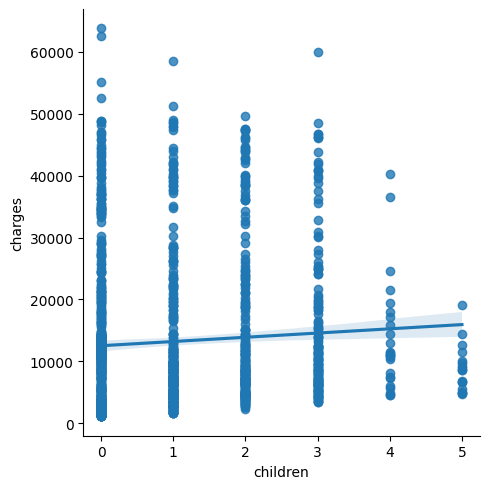

In [15]:
sns.lmplot(x="children", y="charges", data=insurance)

# Cleaning the data
We got our visuals, I don't see any new feature emerging from the existing one, so the next step is to clean the data. Since the dataset doesn't have any null values, or any weird values (200 children, or someone -2 years old), we can take care of the outliers.
Regression models don't like outliers because they'll try very hard not to be wrong for them, but become wrong for the normal values.

In [16]:
# compress high value charges
import numpy as np
# We don't have any charges at 0, but it might happen in the future, log1p avoid any error
y_train_log = np.log1p(y_train)
y_train_log.describe()

count    1070.000000
mean        9.113489
std         0.911454
min         7.023647
25%         8.496718
50%         9.167061
75%         9.726009
max        11.044423
Name: charges, dtype: float64

We also need to change our categorical features into numerical features. Using `OneHotEncoder` will create an array, for each value x of the feature, where all the values are at 0 except x.

In [17]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer

# The numerical pipeline
num_pipeline = make_pipeline(
    SimpleImputer(strategy="median"),
    StandardScaler()
)

# The categorical pipeline
cat_pipeline = make_pipeline(
    SimpleImputer(strategy="most_frequent"),
    OneHotEncoder(handle_unknown='ignore')
)

Let's combine our two pipelines.

In [18]:
from sklearn.compose import make_column_selector, make_column_transformer

preprocessing = make_column_transformer(
    (num_pipeline, make_column_selector(dtype_include=np.number)),
    (cat_pipeline, make_column_selector(dtype_include=object)),
)

X_train_prepared = preprocessing.fit_transform(X_train)
# DO NOT CALL FIT ON THE TEST DATA -> LEAKAGE
X_test_prepared = preprocessing.transform(X_test)

# Chose a model
Let's start simple, with a linear regression model.
## Linear Regression

In [19]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(X_train_prepared, y_train_log)

LinearRegression()

After fitting the model, we can finally test its accuracy using the root mean squared error:
$RMSE(X,h)=\sqrt{\frac{1}{m}\sum^m_{i=1}(h(x^{(i)})-y^{(i)}})^2$

note that $h(x^{(i)})$ is the $i^{th}$ prediction made by our model.

In [21]:
from sklearn.metrics import mean_squared_error

# Get predictions on the training data (log)
lin_reg_predictions_log = lin_reg.predict(X_train_prepared)

# Transform predictions from log back to dollar
final_predictions = np.expm1(lin_reg_predictions_log)

# Get back true labels (not y_train_log)
final_labels = y_train 

# Now calculate the RMSE on the actual dollar amounts
lin_reg_rmse_dollars = np.sqrt(mean_squared_error(final_labels, final_predictions))

print(f"Linear Regression RMSE in dollars: ${lin_reg_rmse_dollars:,.2f}")

Linear Regression RMSE in dollars: $8,389.73


In [28]:
# Get this value in percentage
mean_charge = y_train.mean()
print(lin_reg_rmse_dollars*100/(mean_charge))

62.862838270945865


A linear regression model are this wrong because it's really hard to find a straight line that verifies our complicated charges pattern. For example, smokers tend to pay alot more, but men also, and so does people with a high bmi, it's hard to find the right straight line to fit the curve that comes from these patterns.

## Random Forest Regressor
Let's try with a more powerful model in this case. A random forest does a much better job at finding relations in those intricate patterns.

In [29]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor(random_state=42)
forest_reg.fit(X_train_prepared, y_train_log)

forest_reg_pred = forest_reg.predict(X_train_prepared)
final_forest_reg_pred = np.expm1(forest_reg_pred)
forest_rmse = np.sqrt(mean_squared_error(y_train, final_forest_reg_pred))

print(f"Random Forest RMSE in dollars: ${forest_rmse:,.2f}")
print(f"RMSE as a percentage of the average charge: {forest_rmse*100/mean_charge:.2f}%")

Random Forest RMSE in dollars: $2,394.66
RMSE as a percentage of the average charge: 17.94%


This score is really good, but random forests learn by litteraly learning the data, so it's very possible that it overfitted the training data, the same data that we're testing it on. To avoid that, we can use cross validation.

In [32]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(
    forest_reg,
    X_train_prepared,
    y_train_log,
    scoring="neg_mean_squared_error",
    cv=10,
)

# Apply sqrt to get ROOT mean squared error, and the opposite because we want a loss function, from a score function
forest_rmse_scores = np.sqrt(-scores)
print("Average RMSE (log-space):")
print(f"{forest_rmse_scores.mean():.4f}")

print("\nStandard Deviation of RMSE (log-space):")
print(f"{forest_rmse_scores.std():.4f}")

Average RMSE (log-space):
0.3973

Standard Deviation of RMSE (log-space):
0.0566


## Fine Tune the model
Using Randomized Search, we can get an idea of the best hyperparameters.

In [33]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

# Set up the parameter distributions to search
param_distribs = {
    'n_estimators': randint(low=1, high=200),
    'max_features': randint(low=1, high=12), 
}

forest_reg = RandomForestRegressor(random_state=42)
rnd_search = RandomizedSearchCV(forest_reg, 
                                param_distributions=param_distribs,
                                n_iter=10, 
                                cv=5, 
                                scoring='neg_mean_squared_error',
                                random_state=42)

rnd_search.fit(X_train_prepared, y_train_log)

print("Randomized Search is complete!")

best_log_rmse = np.sqrt(-rnd_search.best_score_)

print(f"\nNew best log-space RMSE: {best_log_rmse:.4f}")
print(f"Old log-space RMSE: 0.3973")

Randomized Search is complete!

New best log-space RMSE: 0.3924
Old log-space RMSE: 0.3973


In [35]:
final_model = rnd_search.best_estimator_
test_predictions_log = final_model.predict(X_test_prepared)

# Convert to dollars
final_test_predictions = np.expm1(test_predictions_log)

final_rmse_dollars = np.sqrt(mean_squared_error(y_test, final_test_predictions))

print(f"Final RMSE in dollars: ${final_rmse_dollars:,.2f}")
final_percentage_error = (final_rmse_dollars / mean_charge) * 100
print(f"Final RMSE as a percentage of the average charge: {final_percentage_error:.2f}%")

Final RMSE in dollars: $4,404.87
Final RMSE as a percentage of the average charge: 33.19%
